In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import experiments
import utils

# RANKINGS

In [7]:
ranker_experiment = experiments.RankerExperiment(base_dir="data/qrels.all.txt")

100%|██████████| 100/100 [00:02<00:00, 39.61it/s]


Pickled model loaded
sigma 0.032857202507491974


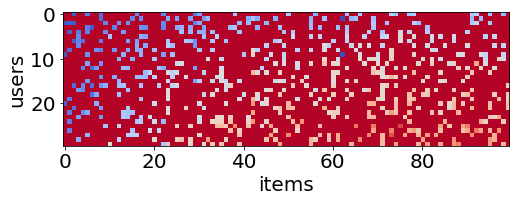

BEST AVAILABLE USER
0.6305206759557395 0.7664582230592845
t-test Ttest_relResult(statistic=-16.553625260049127, pvalue=2.1598044289495105e-48)
z-score 0.7812138764924479
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.6305206759557395 0.79311027499586
t-test Ttest_relResult(statistic=-18.49450965058966, pvalue=3.461642120711767e-57)
z-score 0.8728098740300502
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
0.6305206759557395 0.8086881383689999
t-test Ttest_relResult(statistic=-20.911017180128887, pvalue=2.683212667178026e-68)
z-score 0.9868519152789003
baseline below thresh 0.0
model below thresh 0.0
ORACLE
0.6305206759557395 0.8158530492170998
t-test Ttest_relResult(statistic=-21.95593236876673, pvalue=4.084384541040311e-73)
z-score 1.0361645119033802
baseline below thresh 0.0
model below thresh 0.0


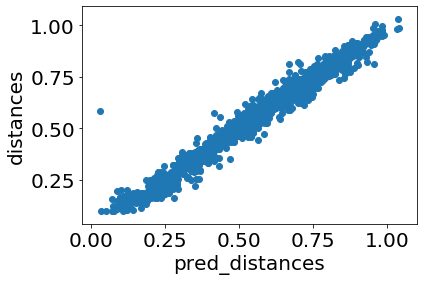

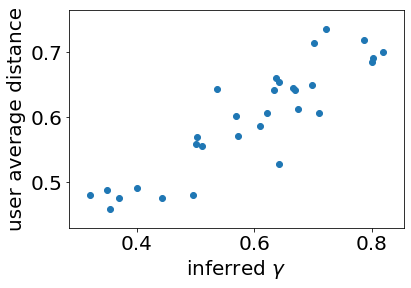

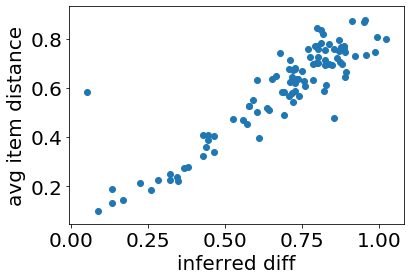

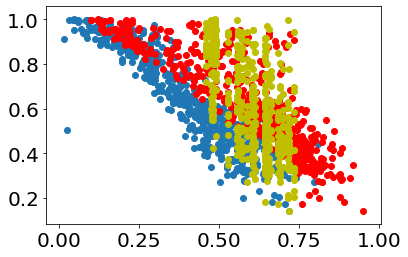


 ALL
ru 0 0.21319711500880875
bau -0.6355306321497469 0.17287995683611795
sad -0.8697365772217629 0.10632384186758756
mas -0.9237154030537424 0.08678160411305041


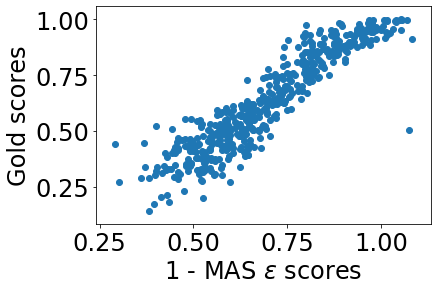

In [13]:
experiments.setup_ranker_manyusers_hiuerr_lodiff(ranker_experiment)
ranker_experiment.distance_fn = lambda x,y: 1 - ranker_experiment.eval_fn(x, y)
nsemisupervised = int(ranker_experiment.stan_data["NITEMS"] / 10)
experiments.set_supervised_items(ranker_experiment, nsemisupervised)

ranker_experiment.train(iter=500)
ranker_experiment.test(debug=True)
ranker_experiment.debug(plot_vs_gold=True, skip_miniplots=True)

In [14]:
ranker_experiment.describe()

30 & 100 & 600 & 20.0$\pm$0.0 & 6.0$\pm$4.74 & 0


100%|██████████| 100/100 [00:02<00:00, 34.29it/s]


Pickled model loaded
sigma 0.02017080967443689


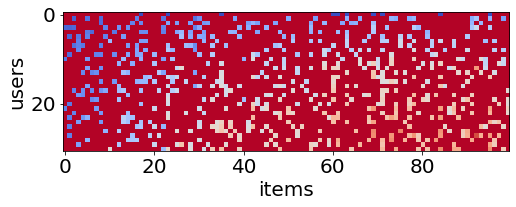

BEST AVAILABLE USER
0.6320936348270118 0.779956928986018
t-test Ttest_relResult(statistic=-18.041467023641797, pvalue=4.047404584243691e-55)
z-score 0.8514294705683125
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.6320936348270118 0.79311027499586
t-test Ttest_relResult(statistic=-19.0984384156105, pvalue=5.924847130943375e-60)
z-score 0.9013110346057864
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
0.6320936348270118 0.8097338637526541
t-test Ttest_relResult(statistic=-21.300562394930733, pvalue=4.288489948865179e-70)
z-score 1.005235690587556
baseline below thresh 0.0
model below thresh 0.0
ORACLE
0.6320936348270118 0.8158530492170998
t-test Ttest_relResult(statistic=-22.664804189795944, pvalue=2.225273552692308e-76)
z-score 1.0696182414969213
baseline below thresh 0.0
model below thresh 0.0


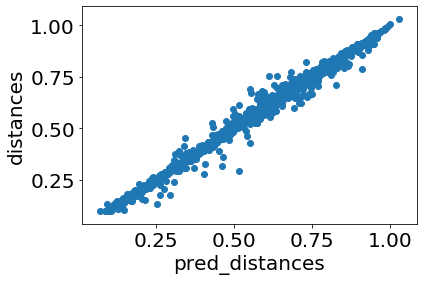

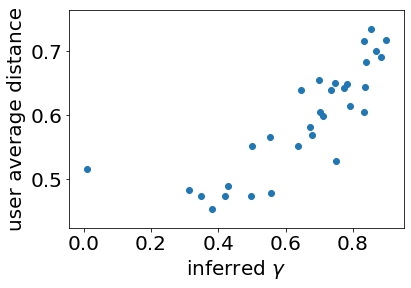

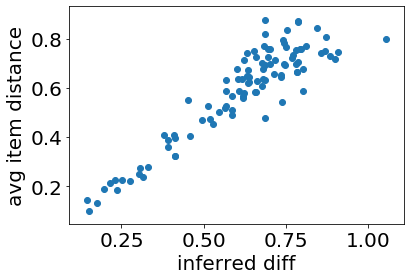

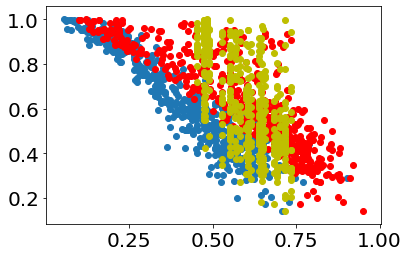


 ALL
ru 0 0.21319711500880875
bau -0.6375082521231192 0.17231693771555576
sad -0.869736577221763 0.10632384186758756
mas -0.939829016914339 0.07920156399240132


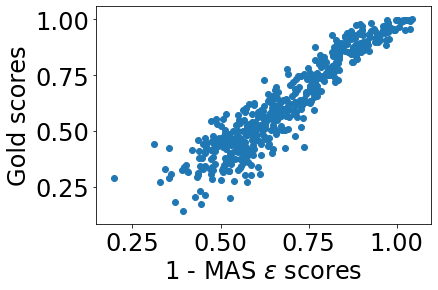

In [15]:
experiments.make_supervised_standata(ranker_experiment)
ranker_experiment.train(iter=1500)
ranker_experiment.test(debug=True)
ranker_experiment.debug(plot_vs_gold=True, skip_miniplots=True)

In [16]:
ranker_experiment.describe()

31 & 100 & 610 & 19.68$\pm$3.54 & 6.1$\pm$5.12 & 0
